# load package

In [1]:
import torch

# import matplotlib.pyplot as plt
# import matplotlib as mpl
# from matplotlib.animation import FuncAnimation
import numpy as np
import spateo as spt
from scipy.sparse import csr_matrix

2024-08-17 02:55:26.310627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
sys.path.append("..")
from data import load_data, data_pre_processing_Drosophila3D_ae

In [3]:
from utils import seed_all
seed_all(123456789)

# load and preprocess data

In [4]:
data_path = '../data/Drosophila3D_after_pp.h5ad'
adata = spt.read_h5ad(data_path)
adata.X = csr_matrix(adata.X)
adata

AnnData object with n_obs × n_vars = 41493 × 2002
    obs: 'area', 'slices', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'auto_anno', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'Size_Factor', 'initial_cell_size', 'time', 'batch', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    obsm: '3d_align_spatial', 'bbox', 'before_3d_align_spatial', 'spliced', 'unspliced'
    layers: 'counts_X', 'log1p_X', 'spliced', 'unspliced'

In [5]:
ae_model_path = '../model_result/Drosophila3D_ae_10.pth'
ae_model = torch.load(ae_model_path, map_location=torch.device('cpu'))
data_pre_processing_Drosophila3D_ae(adata, ae_model=ae_model)

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/pqw/anaconda3/envs/spatial2/lib/python3.8/site-packages/ot/lp/__init__.py:329: UserWarning:

numItermax reached before optimality. Try to increase numItermax.

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100

[[ 0.99905492 -0.02390073  0.0363047 ]
 [ 0.02456418  0.99953728 -0.01793972]
 [-0.03585913  0.01881456  0.99917973]]
264.00992549595236


AnnData object with n_obs × n_vars = 41493 × 2002
    obs: 'area', 'slices', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'auto_anno', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'Size_Factor', 'initial_cell_size', 'time', 'batch', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    obsm: '3d_align_spatial', 'bbox', 'before_3d_align_spatial', 'spliced', 'unspliced', 'X_ae', 'X_input', 'spatial_input'
    layers: 'counts_X', 'log1p_X', 'spliced', 'unspliced'

In [6]:
del adata.layers['spliced'], adata.layers['unspliced'], adata.layers['log1p_X']

In [7]:
model_anno_path = '../model_result/model_anno_Drosophila3D_2.pth'
model_anno = torch.load(model_anno_path, map_location=torch.device('cpu'))

In [8]:
cell_type = np.unique(adata.obs['anno_tissue'])
cell_type_colormap = {
    "CNS": "#5A2686",
    "midgut": "#DC143C",
    "amnioserosa": "#FFDD00",
    "salivary gland": "#FFA500",
    "epidermis": "#ADD8E6",
    "muscle": "#1AAB27",
    "trachea": "#7F90F0",
    "hemolymph": "#CD5C5C",
    "yolk": "#8B0000",
}

# load functions

In [9]:
def get_cell_type(cur_cell, model_anno, t):
    model_anno.eval()
    with torch.no_grad():
        time = torch.tensor(t.repeat(cur_cell.shape[0]), dtype=torch.float32).unsqueeze(1)
        inputs = torch.cat((cur_cell, time), dim=1)
        outputs = model_anno(inputs)
        cell_type_index = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        cur_cell_type = list(cell_type[cell_type_index])
    return cur_cell_type

In [10]:
def growth(x, delta_t, model, t, cur_cell_id, sigma_d=0.00001):
    cell_number = x.shape[0]
    x_growth = []
    new_cell_id = []
    g = model.hyper_net3(torch.tensor(t, dtype=torch.float32), x)
    for i in range(cell_number):
        g_i = g[i, :]
        temp = np.random.rand()
        if g_i > 0 and temp < (g_i * delta_t):
            x_growth.append(x[i, :])
            new_cell_id.append(cur_cell_id[i])
            
            new_cell = x[i, :] + sigma_d * torch.tensor(np.random.randn(x[i, :].shape[0]))
            # new_cell[0:3] = torch.maximum(new_cell[0:3], torch.tensor(0.0))
            x_growth.append(new_cell)
            new_cell_id.append(cur_cell_id[i])
        elif g_i > 0 and temp > (g_i * delta_t):
            x_growth.append(x[i, :])
            new_cell_id.append(cur_cell_id[i])
        elif g_i < 0 and temp > (-g_i * delta_t):
            x_growth.append(x[i, :])
            new_cell_id.append(cur_cell_id[i])
    cur_cell = torch.vstack(x_growth)
    cur_cell = torch.tensor(cur_cell, dtype=torch.float32)
    return cur_cell, new_cell_id

In [11]:
def evolution(init_cell, time_point, fix_type=None):
    all_exp = []
    all_spa = []
    all_cell_type = []
    all_cell_id = []

    cur_cell = init_cell
    cur_cell_id = np.arange(cur_cell.shape[0])
    if fix_type:
        cur_cell_type = [fix_type]*cur_cell.shape[0]
    else:
        cur_cell_type = get_cell_type(init_cell, model_anno, time_point[0])
    
    time_step = time_point[1:] - time_point[0:-1]

    cur_cell = init_cell
    for i in range(len(time_point)):
        all_exp.append(cur_cell[:, 0:-3].detach().numpy())
        all_spa.append(cur_cell[:, -3:].detach().numpy())
        all_cell_id.append(cur_cell_id)
        
        if fix_type:
            cur_cell_type = [fix_type]*cur_cell.shape[0]
        else:
            cur_cell_type = get_cell_type(cur_cell, model_anno, time_point[i])

        all_cell_type.append(cur_cell_type)

        if i < len(time_step):
            cur_cell, cur_cell_id = growth(cur_cell, time_step[i], model, time_point[i], cur_cell_id)
            cur_cell[:, 0:-3] = cur_cell[:, 0:-3] + time_step[i] * model.hyper_net1(
                torch.tensor(time_point[i], dtype=torch.float32), cur_cell)
            cur_cell[:, -3:] = cur_cell[:, -3:] + time_step[i] * model.hyper_net2(
                torch.tensor(time_point[i], dtype=torch.float32), cur_cell)
    return all_exp, all_spa, all_cell_type, all_cell_id

# plot figures

In [12]:
import plot_Drosophila3D_utils
import importlib
importlib.reload(plot_Drosophila3D_utils)

<module 'plot_Drosophila3D_utils' from '/home/pqw/spaot/Drosophila3D_results_figure/plot_Drosophila3D_utils.py'>

In [13]:
spatial_key = 'spatial_input'
integral_time = list(np.unique(adata.obs['time']))
time_pts = range(len(integral_time))

In [14]:
delta_t = 0.1
time_point = np.arange(np.unique(integral_time)[0], np.unique(integral_time)[-1], delta_t)
time_point = np.union1d(time_point, integral_time[-1])
true_time_point = time_point + 8.0

In [15]:
text_kwargs = {"font_size": 7*4}
outline_kwargs = {"font_size": 7*4}
legend_kwargs = {"label_font_size": 7*4,  "title_font_size": 7*4}

text_kwargs_gif = {"font_size": 7*5*10}
outline_kwargs_gif = {"font_size": 7*5}
legend_kwargs_gif = {"label_font_size": 7*5,  "title_font_size": 7*5}

In [16]:
# svae_parameter
show_axes = True
show_legend = True
show_text = True
save_path = './Drosophila3D_show'

## stVCR with biological knowledge guidance term and structural preservation term

In [17]:
adata_bg_sp = adata.copy()

In [18]:
model_path = '../model_result/model_Drosophila3D_bio_localv3_wm2_7.pth'
rigid_transformation_path = '../model_result/rigid_Drosophila3D_bio_localv3_wm2_7.pth'

model = torch.load(model_path, map_location=torch.device('cpu'))
rigid_transformation = torch.load(rigid_transformation_path, map_location=torch.device('cpu'))

In [19]:
for i in time_pts:
    if i > 0:
        spatial_i = torch.tensor(adata_bg_sp[adata_bg_sp.obs.time == integral_time[i], :].obsm[spatial_key].copy(), 
                                 dtype=torch.float32)
        spatial_i = rigid_transformation(spatial_i, i)
        adata_bg_sp.obsm[spatial_key][adata_bg_sp.obs.time == integral_time[i], :] = spatial_i.detach().numpy()

In [21]:
data_train, train_time, integral_time = load_data(adata_bg_sp, device='cpu')
data_train_CNS, _, _ = load_data(adata_bg_sp[adata_bg_sp.obs.anno_tissue=='CNS',:], device='cpu')
data_train_midgut, _, _ = load_data(adata_bg_sp[adata_bg_sp.obs.anno_tissue=='midgut',:], device='cpu')

In [22]:
all_exp, all_spa, all_cell_type, _ = evolution(init_cell=data_train[0], time_point=time_point)
all_exp_CNS, all_spa_CNS, all_cell_type_CNS, _ = evolution(init_cell=data_train_CNS[0], 
                                                           time_point=time_point, fix_type='CNS')
all_exp_midgut, all_spa_midgut, all_cell_type_midgut, _ = evolution(init_cell=data_train_midgut[0], 
                                                                    time_point=time_point, fix_type='midgut')

../model.py:125: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_6284/3881466241.py:24: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

../model.py:85: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



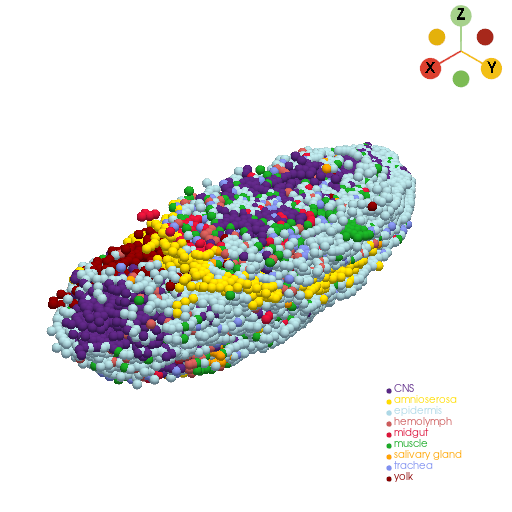

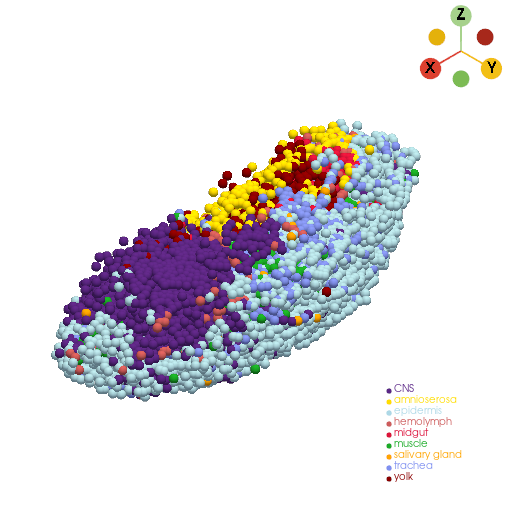

In [23]:
filename = '/figures_all_type/with_bio_sp/E7to9.pdf'
filename = save_path+filename 
plot_Drosophila3D_utils.plot_from_adata(adata_bg_sp[adata_bg_sp.obs.batch=='E7-9h', :], filename, type_key='anno_tissue', subtype=None, spatial_key='spatial_input', 
                cell_type_colormap=cell_type_colormap, text_kwargs=text_kwargs, outline_kwargs=outline_kwargs,
                                       legend_kwargs = legend_kwargs, show_legend=show_legend)

filename = '/figures_all_type/with_bio_sp/E9to10.pdf'
filename = save_path+filename
plot_Drosophila3D_utils.plot_from_adata(adata_bg_sp[adata_bg_sp.obs.batch=='E9-10h', :], filename, type_key='anno_tissue', subtype=None, spatial_key='spatial_input', 
                cell_type_colormap=cell_type_colormap, text_kwargs=text_kwargs, outline_kwargs=outline_kwargs,
                                       legend_kwargs = legend_kwargs, show_legend=show_legend)

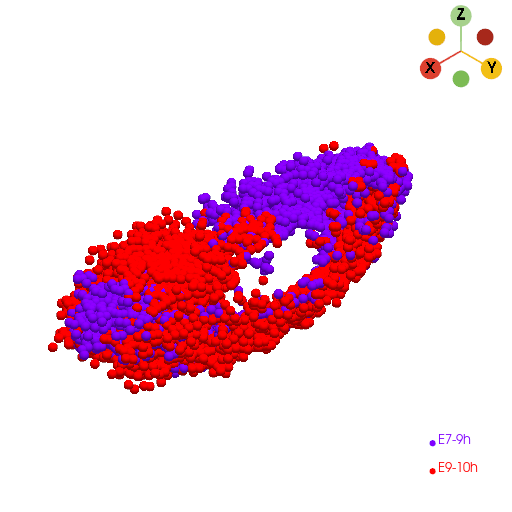

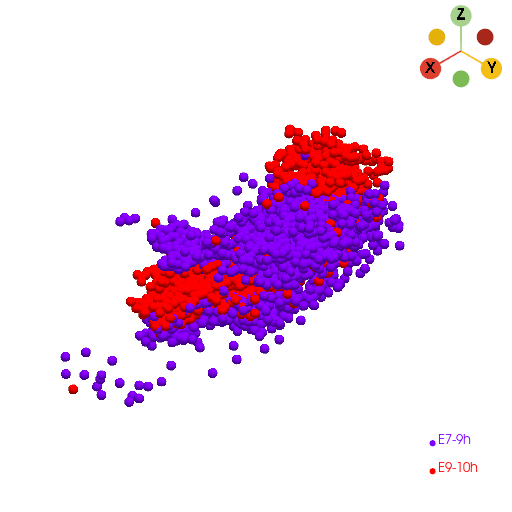

In [24]:
filename = '/figures_CNS/with_bio_sp/CNS_2point.pdf'
filename = save_path+filename 
plot_Drosophila3D_utils.plot_from_adata(adata_bg_sp[adata_bg_sp.obs.anno_tissue=='CNS', :], filename, 
                                        type_key='batch', subtype=None, spatial_key='spatial_input',
                                       text_kwargs=text_kwargs, outline_kwargs=outline_kwargs,
                                        show_legend=show_legend)

filename = '/figures_midgut/with_bio_sp/midgut_2point.pdf'
filename = save_path+filename 
plot_Drosophila3D_utils.plot_from_adata(adata_bg_sp[adata_bg_sp.obs.anno_tissue=='midgut', :], filename, 
                                        type_key='batch', subtype=None, spatial_key='spatial_input',
                                       text_kwargs=text_kwargs, outline_kwargs=outline_kwargs,
                                       show_legend=show_legend)

In [25]:
filename = '/figures_CNS/with_bio_sp/CNS_with_bio_sp.gif'
filename = save_path+filename 
save_image = True
plot_Drosophila3D_utils.plot_3d_gif(all_spa_CNS, all_cell_type_CNS, true_time_point, 
                                    cell_type_colormap=cell_type_colormap,filename=filename, 
                                    spatial_key='spatial_input', cpo=None, key="tissue", model_style='points', 
                                    jupyter="static", model_size = 10, fps=5, save_image=save_image,
                                   text_kwargs=text_kwargs_gif, outline_kwargs=outline_kwargs_gif,
                                   legend_kwargs = legend_kwargs_gif, 
                                    show_legend=show_legend, show_axes=show_axes, show_text=show_text)

In [26]:
filename = '/figures_midgut/with_bio_sp/midgut_with_bio_sp.gif'
filename = save_path+filename 
save_image = True
plot_Drosophila3D_utils.plot_3d_gif(all_spa_midgut, all_cell_type_midgut, true_time_point, 
                                    cell_type_colormap=cell_type_colormap, filename=filename, 
                                    spatial_key='spatial_input', cpo=None, key="tissue", model_style='points', 
                                    jupyter="static", model_size = 10, fps=5, save_image=save_image,
                                   text_kwargs=text_kwargs_gif, outline_kwargs=outline_kwargs_gif,
                                   show_legend=show_legend, show_axes=show_axes, show_text=show_text)

In [27]:
filename = '/figures_all_type/with_bio_sp/all_type_with_bio_sp.gif'
filename = save_path+filename 
save_image = True
plot_Drosophila3D_utils.plot_3d_gif(all_spa, all_cell_type, true_time_point, 
                                    cell_type_colormap=cell_type_colormap, filename=filename, 
                                    spatial_key='spatial_input', cpo=None, key="tissue", model_style='points', 
                                    jupyter="static", model_size = 10, fps=5, save_image=save_image,
                                   text_kwargs=text_kwargs_gif, outline_kwargs=outline_kwargs_gif,
                                   show_legend=show_legend, show_axes=show_axes, show_text=show_text)